In [1]:
import sys
if "../" not in sys.path:  # to get my usual helpers at base dir
    sys.path.append("../")

import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
from lightkurve_ext import TransitTimeSpec, TransitTimeSpecList
import lightkurve_ext_tess as lket
import lightkurve_ext_pg as lke_pg
import lightkurve_ext_pg_runner as lke_pg_runner
import tic_plot as tplt

import asyncio_compat

import math
import re
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time, TimeDelta
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7


# No longer works in Jupyter 7+
display(Javascript("""
// export notebook url to Python for bokeh-based interactive features
if (window["IPython"] != null) {
  IPython.notebook.kernel.execute(`notebook_url = "${window.location.origin}"`);
} else {
  console.warn("IPython js object not available (in Jupyter 7). Hardcode notebook_url in the notebook itself instead.")
}
"""));
notebook_url = "localhost:8888"

%matplotlib inline

# data cache config
lk_download_dir = '../data'
if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir

# make markdown table aligned to the left of the cell output (instead of center)
display(HTML("<style>table {margin-left: 4ch;}</style>"))

<IPython.core.display.Javascript object>

# TIC 394728064  Analysis (EA)

- revise existing https://www.aavso.org/vsx/index.php?view=detail.top&oid=9377 (marked as EA with incorrect period)

## TESS Data



In [3]:
tic = 394728064

sr = lk.search_lightcurve(f"TIC{tic}", )  # author="SPOC", cadence="short"
sr = lke.filter_by_priority(sr, author_priority = ["SPOC", "TESS-SPOC", "QLP"])

astropy.table.pprint.conf.max_lines = 100  # to print all rows
display(sr)

lcc_tess = sr.download_all()
lcc_tess

#,mission,year,author,exptime,target_name,distance,proposal_id
,,,,s,,arcsec,
0,TESS Sector 11,2019,SPOC,120,394728064,0.0,"G011155 , G011270"
1,TESS Sector 12,2019,SPOC,120,394728064,0.0,"G011155 , G011270"
2,TESS Sector 38,2021,SPOC,120,394728064,0.0,G03209
3,TESS Sector 39,2021,SPOC,120,394728064,0.0,G03209
4,TESS Sector 64,2023,SPOC,120,394728064,0.0,"G05116 , G05139 , G05003"
5,TESS Sector 65,2023,SPOC,120,394728064,0.0,"G05116 , G05139 , G05003"
6,TESS Sector 66,2023,SPOC,120,394728064,0.0,"G05116 , G05139 , G05003"


LightCurveCollection of 7 objects:
    0: <TessLightCurve LABEL="TIC 394728064" SECTOR=11 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 394728064" SECTOR=12 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 394728064" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 394728064" SECTOR=39 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 394728064" SECTOR=64 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 394728064" SECTOR=65 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 394728064" SECTOR=66 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

In [4]:
# List of all TCEs of the TIC
display(HTML(lket.get_tic_meta_in_html(tic, download_dir=lk_download_dir)))

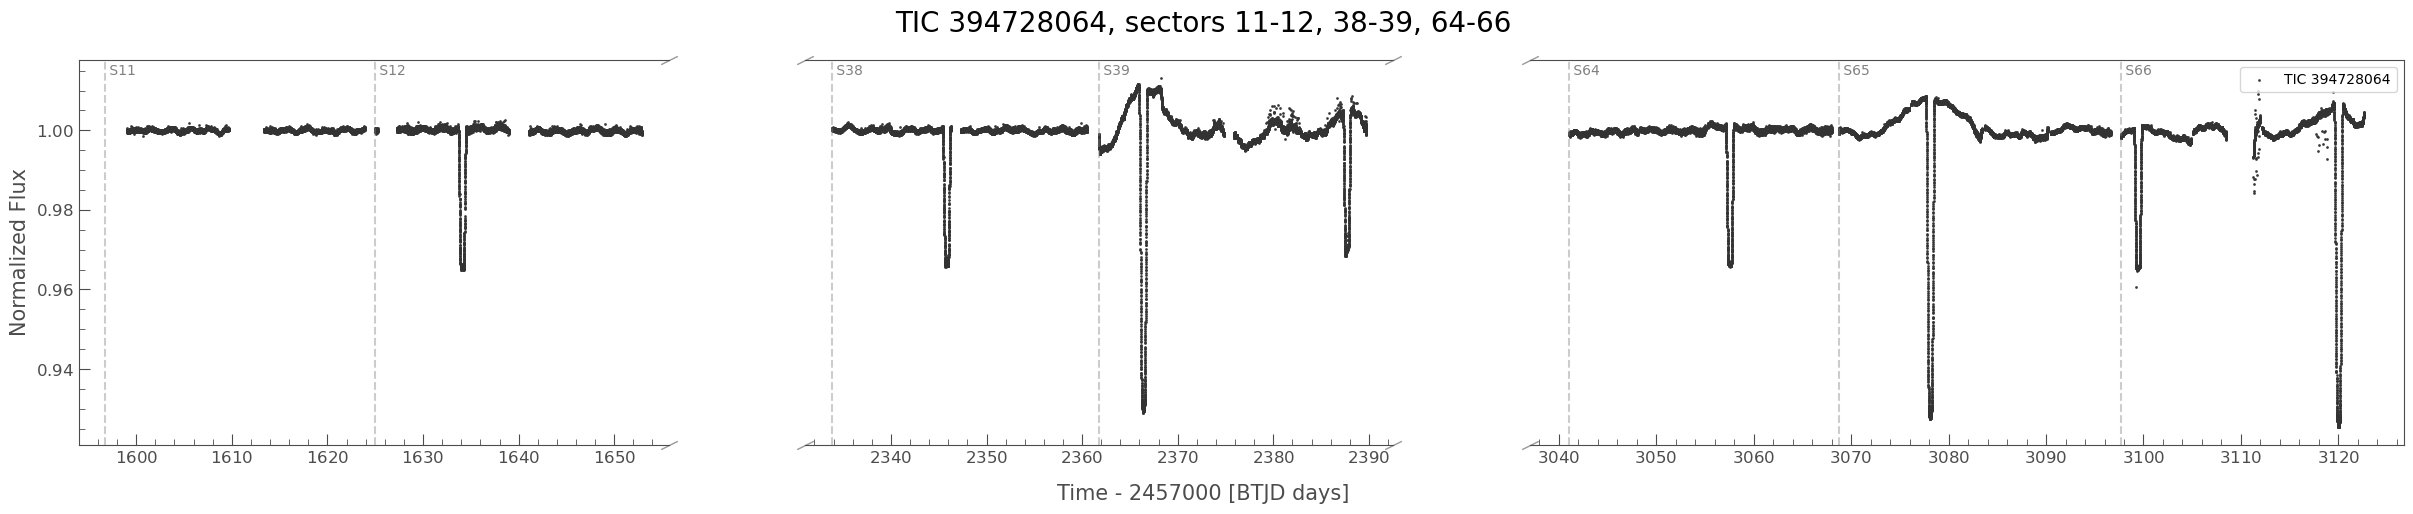

In [5]:
lc = lke.stitch(
    lcc_tess,
    ignore_incompatible_column_warning=True,    
)

axs = tplt.plot_skip_data_gap(lc, figsize=(30,5), s=4, alpha=0.9);
axs[0].get_figure().suptitle(f"{lc.label}, sectors {lke.abbrev_sector_list(lc)}", fontsize=20);

---

## Gaia DR3 info (coordinate, etc.)

In [6]:
rs_all_cols, rs, rs_html  = lket.search_gaiadr3_of_tics(tic)
display(HTML(rs_html))

# from Gaia DR3
target_coord = SkyCoord(rs[0]["RAJ2000"], rs[0]["DEJ2000"], unit=(u.deg, u.deg), frame="icrs")
target_coord_dict = dict(ra=target_coord.ra.value, dec=target_coord.dec.value)


In [7]:
primary_name = f"DR Cha"  # Existing VSX name


## Hipparcos data

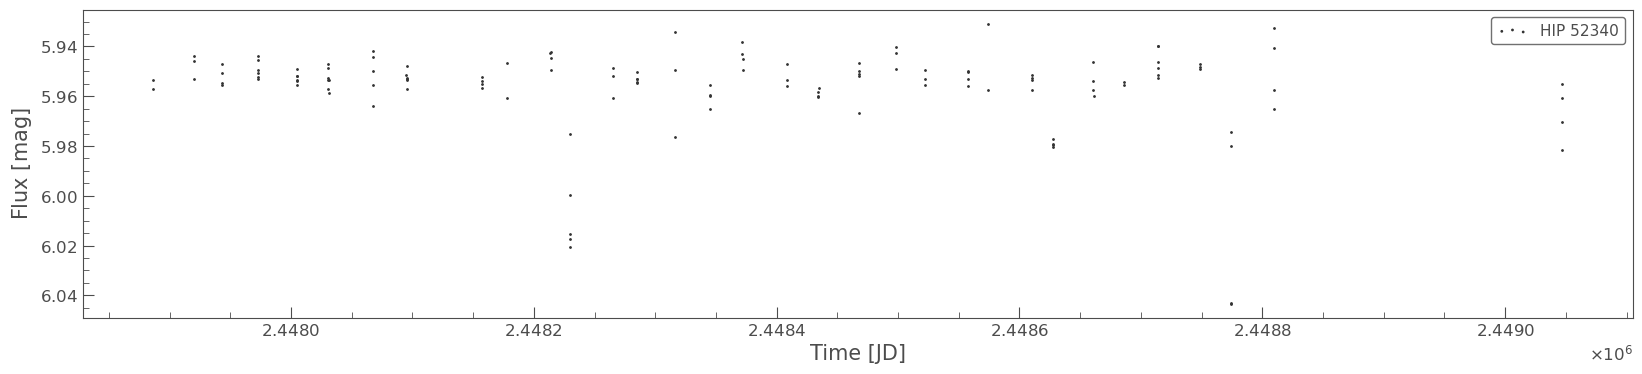

In [27]:
# %matplotlib widget
%matplotlib inline

import lightkurve_ext_readers as lker
# reload(lker)


lc = lker.read_hipparcos_data("https://cdsarc.cds.unistra.fr/viz-bin/nph-Plot/Vgraph/txt?I/239/52340")

ax = tplt.lk_ax(figsize=(20, 4))
ax = tplt.scatter(lc, ax=ax);

lc_hip = lc  # keep the reference in a meaninfgul name for use in subsequent cells

## Combining TESS and Hipparcos data

TESS # data points: 131868
Hipparcos # data points: 132


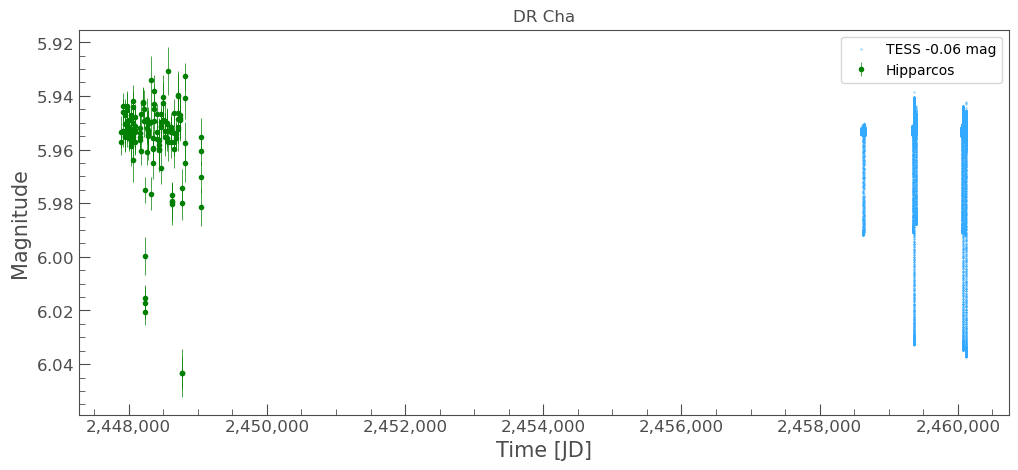

In [28]:
# Convert the data to magnitude and HJD/UTC

import lightkurve_ext_multi_sources as lkem
# reload(lkem)

lc_tess = lke.stitch(lcc_tess, ignore_incompatible_column_warning=True, )

lc_tess = lke.convert_lc_time_to_hjd_utc(lc_tess, target_coord=target_coord, cache_dir=lk_download_dir)
lc_tess = lke.to_flux_in_mag_by_normalization(lc_tess)
# axs = tplt.plot_skip_data_gap(lc_tess, figsize=(30,5), s=4, alpha=0.9);

lc_combined_dict = lkem.combine_multi_bands_and_shift(
    {"TESS": lc_tess, 
     "Hipparcos": lc_hip,
    }, 
    shift_to="Hipparcos")

for k in lc_combined_dict.keys():
    print(f"{k} # data points:", len(lc_combined_dict[k]))

ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(12, 5), target_name=primary_name);


## Determine period by using both TESS and Hipparcos data

In [35]:
# epoch=3287.5580, duration_hr=3.3745, period=2.039652, label="s0073-s0073:TCE1",

#
# Tentative Eclipse parameters, from s0003-s0073:TCE1 above
#

period_initial = 41.8667
epoch_time_btjd = 1612.80
epoch_time_hjd = lke.to_hjd_utc(Time(epoch_time_btjd, format="btjd"), target_coord).value
epoch_time_hjd = round(epoch_time_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

epoch_time_min_ii_btjd = epoch_time_btjd + 21.333
epoch_time_min_ii_hjd = lke.to_hjd_utc(Time(epoch_time_min_ii_btjd, format="btjd"), target_coord).value
epoch_time_min_ii_hjd = round(epoch_time_min_ii_hjd, 3)  # for VSX reporting, 3 digit precision (~1.44 min) is more than enough

duration_hr_min_i_initial = 20.96
duration_hr = duration_hr_min_i_initial   # default shorthand 

duration_hr_min_ii_initial = duration_hr_min_i_initial  # roughly the same as min i

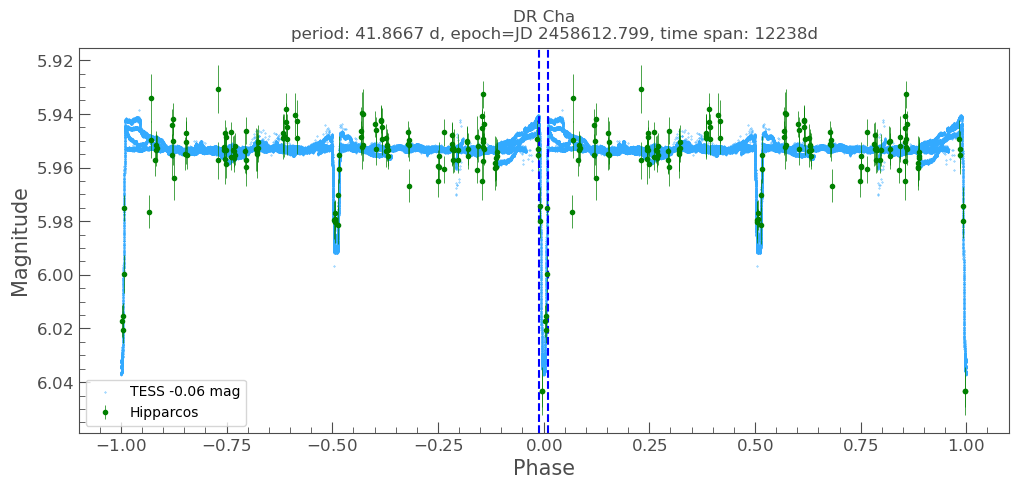

In [33]:
%matplotlib inline
# %matplotlib widget

reload(lkem)
ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    period=period_initial,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
    target_name=primary_name,
    duration_hr=duration_hr_min_i_initial,  # for plotting only
    figsize=(12, 5),
    mag_shift_precision=2,  # the TESS lightcurve is very rough anyway 

);

# ax.set_ylim(11.85, 11.65);
# ax.set_xlim(-0.1, 0.1);  # to see primary in details

Adopted period:  41.8667
Min II phase:  0.5095457726546416


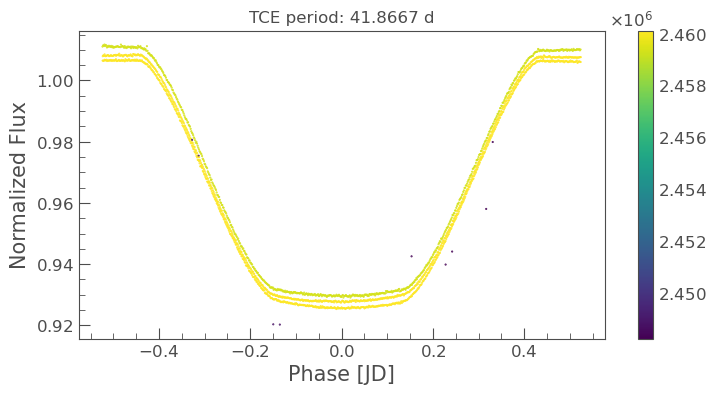

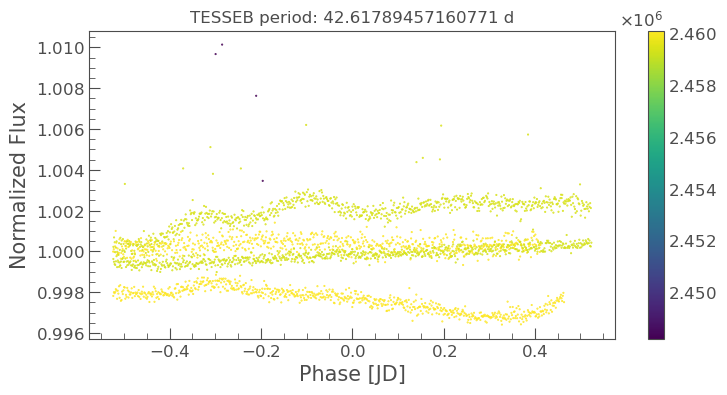

In [46]:
period_tce = 41.8667  # https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC394728064S0001S0069TCE2
period_tesseb = 42.61789457160771  # -- https://tessebs.villanova.edu/394728064

lc = lke.to_normalized_flux_from_mag(lk.LightCurveCollection(lc_combined_dict.values()).stitch(corrector_func=lambda lc: lk.LightCurve(time=lc.time, flux=lc.flux, flux_err=lc.flux_err)))

for per_method, per in dict(TCE=period_tce, TESSEB=period_tesseb).items():
    lc_f = lc.fold(period=per, epoch_time=epoch_time_hjd)
    lc_f = lc_f.truncate(0 - 0.6 * duration_hr / 24, 0 + 0.6 * duration_hr / 24);
    ax = tplt.scatter(lc_f, s=1, c=lc_f.time_original.value);
    ax.set_title(f"{per_method} period: {per} d")

# Cannot tell the difference between TCE period and BLS period, cut 1 digit and choose the best
period_final = period_tce
print("Adopted period: ", period_final)

# Can precsiely define Min II phase, with period finalized
epoch_phase_min_ii = (epoch_time_min_ii_btjd - epoch_time_btjd) / period_final
print("Min II phase: ", epoch_phase_min_ii)

## Determine Amplitude

['6.01', '6.10', '6.05']
['6.01', '0.08', '0.04']


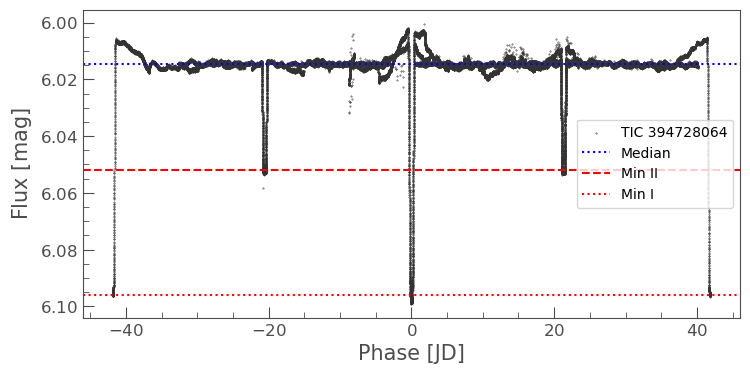

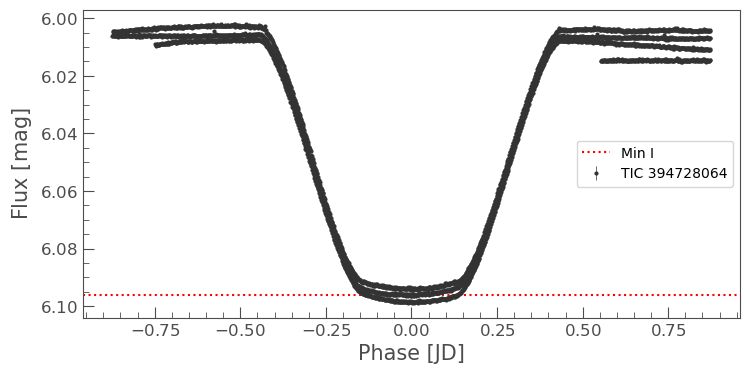

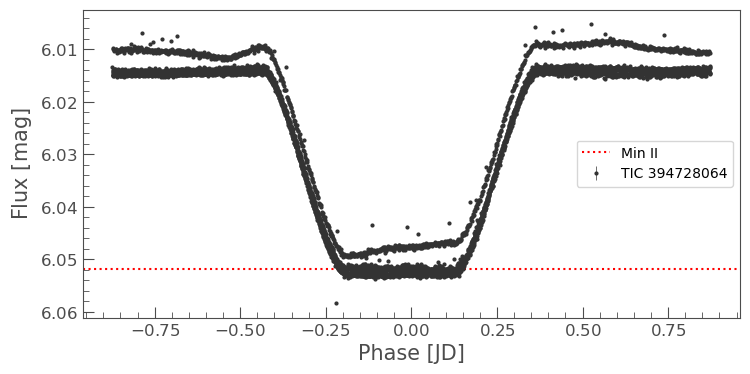

In [37]:
# From TESS data (shifted back to TESS mag)

lc = lc_combined_dict["TESS"]
lc = lc - lc.flux_shift
# max_flux_mag = lc.flux.min().value  #
min_flux_mag = lc.flux.max().value
median_flux_mag = np.nanmedian(lc.flux.value)

lc_zoom_min = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - 1/24/60, 0 + 1/24/60)
min_flux_mag = np.nanmedian(lc_zoom_min.flux.value)
min_amp_mag = abs(min_flux_mag - median_flux_mag) 

# fold around Min II, find the min flux
lc_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - 1/24/60, 0 + 1/24/60)
min_ii_flux_mag = np.nanmedian(lc_zoom_min_ii.flux.value)
min_ii_amp_mag = abs(min_ii_flux_mag - median_flux_mag) 

lc_f = lc.fold(epoch_time=epoch_time_hjd, period=period_final * 2)  # 2x period plot
ax = tplt.scatter(lc_f, s=0.5);
ax.axhline(median_flux_mag, c="blue", linestyle="dotted", label="Median")
ax.axhline(min_ii_flux_mag, c="red", linestyle="dashed", label="Min II")
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_i = lc.fold(epoch_time=epoch_time_hjd, period=period_final).truncate(0 - duration_hr / 24, 0 + duration_hr / 24)
ax = tplt.errorbar(lc_f_zoom_min_i, marker="o");
ax.axhline(min_flux_mag, c="red", linestyle="dotted", label="Min I")
ax.legend();

lc_f_zoom_min_ii = lc.fold(epoch_time=epoch_time_min_ii_hjd, period=period_final).truncate(0 - duration_hr_min_ii_initial / 24, 0 + duration_hr_min_ii_initial / 24)
ax = tplt.errorbar(lc_f_zoom_min_ii, marker="o");
ax.axhline(min_ii_flux_mag, c="red", linestyle="dotted", label="Min II")
ax.legend();

print([f"{v:.2f}" for v in [median_flux_mag, min_flux_mag, min_ii_flux_mag]])
print([f"{v:.2f}" for v in [median_flux_mag, min_amp_mag, min_ii_amp_mag]])

## Plots for VSX

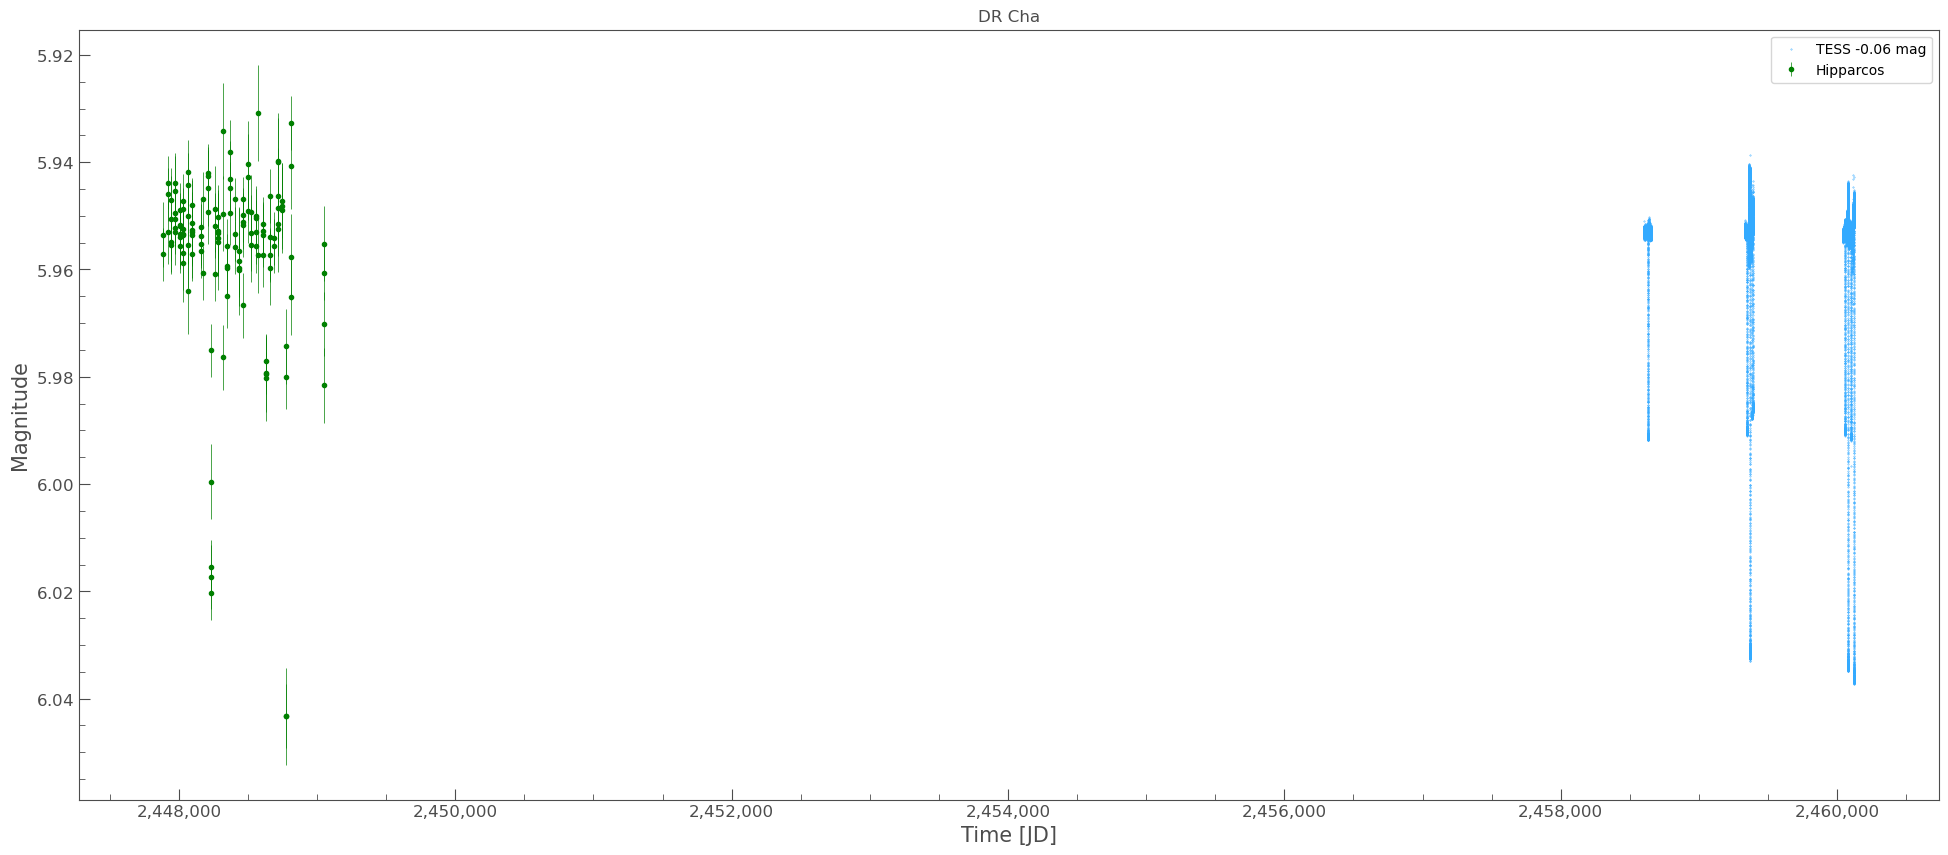

In [39]:
# reload(lkem)
ax = lkem.plot_multi_bands(lc_combined_dict, figsize=(24, 10), target_name=primary_name);
# ax.set_ylim(12.8, 11.9);

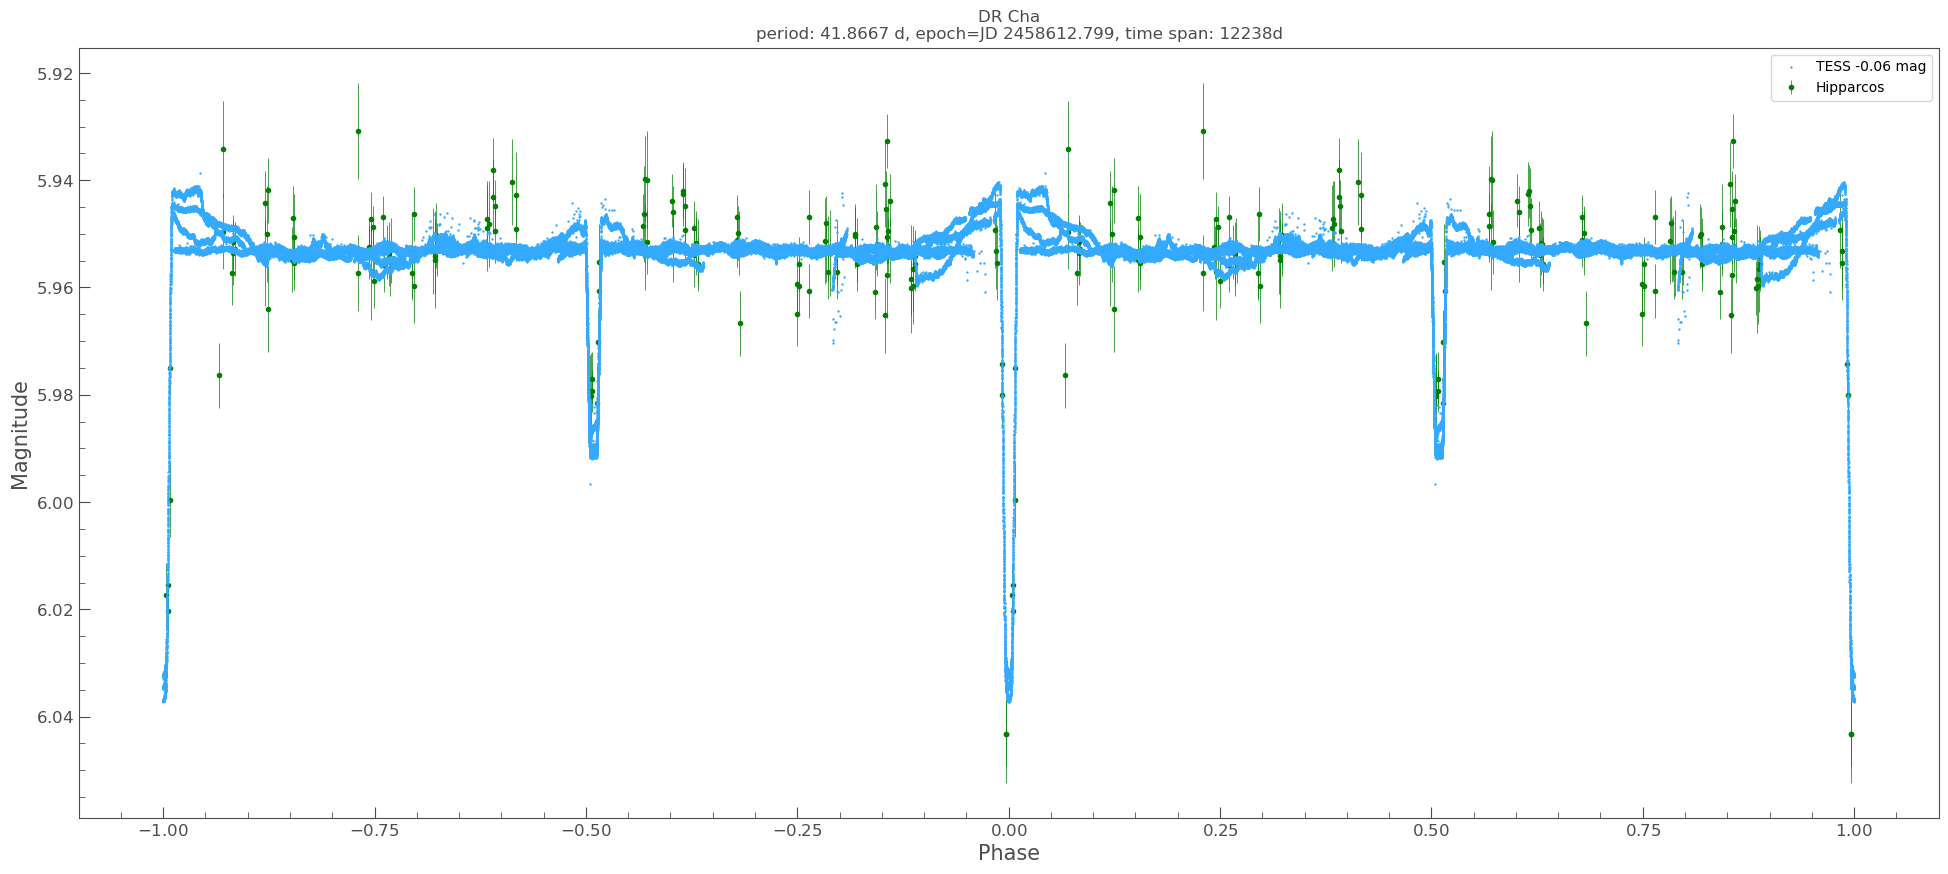

In [55]:
reload(lkem)

plot_options = lkem.get_default_plot_multi_bands_options_copy()
# for TESS plot (index 0) increase the marker size and move it to the front, to make TESS data more visible, its data is not rather sparse
plot_options[0][1]["s"] = 0.5  # default 0.1
plot_options[0][1]["zorder"] = 3  # default 2

ax, lc_f_res = lkem.fold_n_plot_multi_bands(
    lc_combined_dict,
    # dict(TESS=lc_combined_dict["TESS"]),   to show TESS data only
    period=period_final,
    epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
    phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1    
    figsize=(24, 10),
    target_name=primary_name,
    plot_options=plot_options,
);


In [170]:
# reload(lkem)
# ax, lc_f_res = lkem.fold_n_plot_multi_bands(
#     dict(TESS=lc_tess),
#     period=period_final,
#     epoch=Time(epoch_time_hjd, format="jd", scale="utc"),
#     phase_scale=2,  #  fold at  period, i.e., plot from phase -1 to +1
#     figsize=(24, 10),
#     target_name=primary_name,
# );

## VSX Report Table

In [43]:
def report_to_df(report):
    df = pd.DataFrame()
    df["Field"] = report.keys()
    df["Value"] = report.values()
    return df

In [53]:
import bibs_utils
reload(bibs_utils)

other_names = f"TIC {tic}"  # include TIC
other_names += ",2MASS J10415155-7946598,TYC 9418-2651-1,WISEA J104151.46-794659.6"  # from TIC xmatch with SIMBAD and ASAS-SN Variable
# other_names += ",GSC 07714-02184"  # N/A (already there) Vizier, https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ662464d61cfcb6&-out.add=.&-source=I/255/out&GSC=0771402184

remarks = f"Eccentric system. Min I amplitude {min_amp_mag:.2f} TESS. Min II at phase {epoch_phase_min_ii:.2f}, amplitude {min_ii_amp_mag:.2f} TESS, duration {100 * duration_hr_min_ii_initial / 24 / period_final:.0f}%."
    
revision_comment = "Period, epoch, eclipse duration from TESS and Hipparcos data. Amplitudes from TESS data. Position from Gaia DR3."

BIBS = bibs_utils.BIBS

vsx_report = dict(
    Position=f"{target_coord.ra.value}, {target_coord.dec.value}",
    Primary_Name=primary_name,
    Other_Names=other_names,
    Variable_Type="EA",
    # Spectral_Type="",   # no change
    # Spectral_Type_Uncertain=False,
    # Maximum_Magnitude=f"{median_flux_mag_asassn_v:.2f}",  # no change
    # Maximum_Magnitude_band="V",
    # Minimum_Magnitude=f"{min_amp_mag:.2f}",
    # Minimum_Magnitude_band="TESS",  
    # Minimum_Is_Amplitude=True,
    Period=period_final,
    Epoch=epoch_time_hjd,
    Rise_Duration_Pct=f"{100 * duration_hr_min_i_initial / 24 / period_final:.0f}",
    # Discoverer="",  
    Remarks=remarks,
    Revision_Comment=revision_comment,
    Reference1_Name=BIBS.TESS_N,
    Reference1_Bib=BIBS.TESS_B,
)

def print_long_fields(report):
    other_names_list = report["Other_Names"].split(",")
    print("Other Names (1 line each):")
    print("\n".join(other_names_list))
    print("")
    print(report["Remarks"])
    print("")
    print(report["Revision_Comment"])

print_long_fields(vsx_report)
with pd.option_context('display.max_colwidth', None):
    display(report_to_df(vsx_report))

# Uploaded plots with  descriptions
print("""
tic394728064_combined_plot.png: Combined light curve - Combined light curve from Hipparcos and TESS, shifted to Hipparcos.
tic394728064_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from  Hipparcos and TESS, shifted to Hipparcos.
""")


Other Names (1 line each):
TIC 394728064
2MASS J10415155-7946598
TYC 9418-2651-1
WISEA J104151.46-794659.6

Eccentric system. Min I amplitude 0.08 TESS. Min II at phase 0.51, amplitude 0.04 TESS, duration 2%.

Period, epoch, eclipse duration from TESS and Hipparcos data. Amplitudes from TESS data. Position from Gaia DR3.


,Field,Value
0,Position,"160.46466843894, -79.78328811002"
1,Primary_Name,DR Cha
2,Other_Names,"TIC 394728064,2MASS J10415155-7946598,TYC 9418-2651-1,WISEA J104151.46-794659.6"
3,Variable_Type,EA
4,Period,41.8667
5,Epoch,2458612.799
6,Rise_Duration_Pct,2
7,Remarks,"Eccentric system. Min I amplitude 0.08 TESS. Min II at phase 0.51, amplitude 0.04 TESS, duration 2%."
8,Revision_Comment,"Period, epoch, eclipse duration from TESS and Hipparcos data. Amplitudes from TESS data. Position from Gaia DR3."
9,Reference1_Name,"Ricker, G. R.; et al., 2014, Transiting Exoplanet Survey Satellite (TESS)"



tic394728064_combined_plot.png: Combined light curve - Combined light curve from Hipparcos and TESS, shifted to Hipparcos.
tic394728064_phase_plot_eclipses.png : EA Phase Plot - EA Phase Plot of the target from  Hipparcos and TESS, shifted to Hipparcos.



# Scratch